In [1]:
import pandas as pd
import numpy as np
import torch
from fastai.tabular.all import *

In [2]:
import matplotlib.pyplot as plt

In [3]:
sales = pd.read_csv('./input/cleanedmonthly.csv')
items = pd.read_csv('./input/items.csv')

In [4]:
x = sales.loc[sales.shop_id==14].groupby(['date_block_num']).agg({'item_cnt_month': 'mean'})

In [5]:
x

,item_cnt_month
date_block_num,
0,1.950397
1,2.158000
2,2.269871
3,1.719912
4,2.069170
5,2.347349
6,2.042139
7,2.376453
8,2.518519


In [6]:
X = x.index.values
y = x.item_cnt_month.values

In [7]:
degree = 5

In [8]:
coef = np.polyfit(X, y, degree)

Coefficients: [-9.21077856e-07  7.59785470e-05 -2.10173885e-03  1.96000472e-02
 -4.61651025e-03  1.99500111e+00]


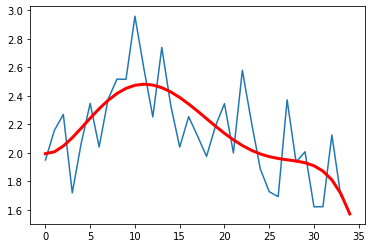

In [9]:
print('Coefficients: %s' % coef)
# create curve
curve = list()
powers = np.array(range(degree+1))
powers = powers[::-1]
for i in range(len(X)+1):
    xs = np.ones(degree+1)*i
    value = ((xs**powers)*coef).sum()
    curve.append(value)
# plot curve over original data
curve = np.array(curve)
curve = np.where(curve>0, curve, 0)
plt.plot(y)
plt.plot(curve, color='red', linewidth=3);

In [10]:
coef

array([-9.21077856e-07,  7.59785470e-05, -2.10173885e-03,  1.96000472e-02,
       -4.61651025e-03,  1.99500111e+00])

In [11]:
curve

array([1.99500111, 2.00795796, 2.04854055, 2.10673549, 2.17413186,
       2.2438106 , 2.31023405, 2.36913536, 2.41740801, 2.45299524,
       2.47477956, 2.4824722 , 2.47650256, 2.45790773, 2.42822191,
       2.38936592, 2.34353664, 2.29309651, 2.24046298, 2.18799798,
       2.13789741, 2.09208057, 2.0520797 , 2.01892938, 1.99305603,
       1.97416739, 1.96114198, 1.95191857, 1.94338564, 1.93127089,
       1.91003065, 1.87273942, 1.81097928, 1.71472939, 1.57225546])

In [12]:
shops = sales.shop_id.unique()
degree = 5

In [13]:
def generate_values(dateblocks, sales_cnt, shop, coeffs, pol_deg):
    dateblocks = dateblocks.tolist()
    dateblocks.append(34)
    sales_cnt = sales_cnt.tolist()
    sales_cnt.append(0)
    curve = list()
    powers = np.array(range(pol_deg+1))
    powers = powers[::-1]
    shop_id = (np.ones(len(dateblocks))*shop).astype(np.int64)
    for i in dateblocks:
        xs = np.ones(pol_deg+1)*i
        value = ((xs**powers)*coeffs).sum()
        curve.append(value)
    curve = np.array(curve)
    curve = np.where(curve>0, curve, 0)
    return pd.DataFrame({'shop_id':shop_id, 
                         'date_block_num': dateblocks, 
                         'seasonality': curve, 
                         'item_cnt_month': sales_cnt})
    

In [14]:
seasonality_vals = list()
for shop in shops:
    sales_item = sales.loc[sales.shop_id==shop].groupby(['date_block_num']).agg({'item_cnt_month': 'mean'})
    X = sales_item.index.values
    y = sales_item.item_cnt_month.values
    if len(X)>5:
        coef = np.polyfit(X, y, degree)
        seasonality_vals.append(generate_values(X, y, shop, coef, degree))

In [15]:
seasonal_variation = pd.concat(seasonality_vals)

In [16]:
seasonal_variation

,shop_id,date_block_num,seasonality,item_cnt_month
0,2,0,1.577267,1.672000
1,2,1,1.646300,1.608911
2,2,2,1.708434,1.880597
3,2,3,1.765384,1.542169
4,2,4,1.818490,1.581301
...,...,...,...,...
12,34,30,1.575891,1.586207
13,34,31,1.541595,1.518750
14,34,32,1.528018,1.580524
15,34,33,1.590968,1.571429


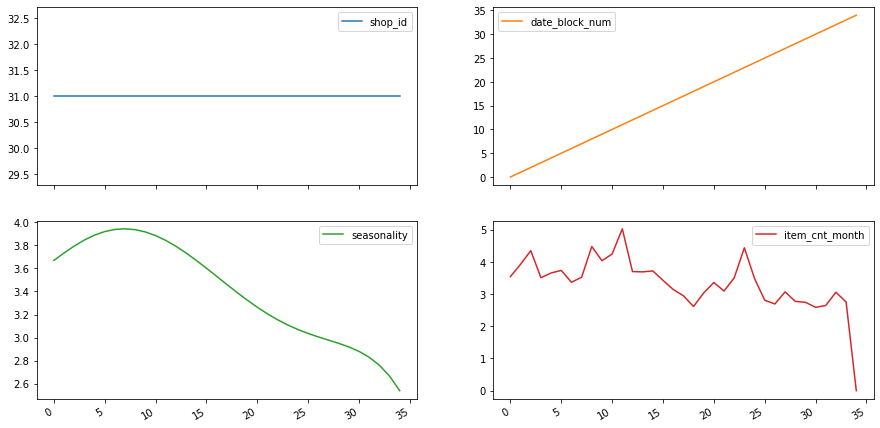

In [17]:
seasonal_variation.loc[seasonal_variation.shop_id==31].plot(subplots=True, figsize=(15, 8), layout=(2,2));

In [18]:
mask = np.isin(sales.shop_id.unique(), seasonal_variation.shop_id.unique())

In [19]:
sales.shop_id.unique()[~mask]

array([36])

In [20]:
dummy_36 = seasonal_variation.groupby('date_block_num').agg({'seasonality': 'mean'})

In [21]:
dummy_36

,seasonality
date_block_num,
0,2.176231
1,2.213342
2,2.260225
3,2.297935
4,2.331230
5,2.366475
6,2.387098
7,2.396715
8,2.398355


In [22]:
ids = (np.ones(35)*36).astype(np.int64)
sv_36 = pd.DataFrame({'shop_id': ids, 'seasonality': dummy_36.seasonality})
sv_36.reset_index(inplace=True)

In [23]:
seasonal_variation.drop(columns='item_cnt_month', inplace=True)

In [24]:
seasonal_variation = pd.concat([seasonal_variation, sv_36])

In [25]:
seasonal_variation.shape

(1407, 3)

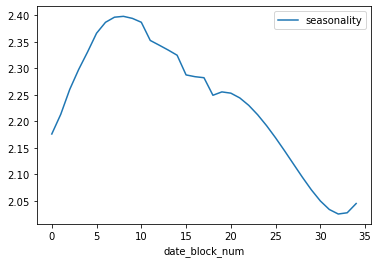

In [26]:
dummy_36.plot()

In [27]:
seasonal_variation.to_csv('./input/shop_seasonality.csv', index=False)

In [28]:
dummy_36.to_csv('./input/general_seasonality.csv')